<a href="https://colab.research.google.com/github/im-vne/Snakes-or-No-Snakes/blob/main/1200%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model building and evaluation

This notebook contains the main two methods: CNN and logistic regression. For side analyses see their specific notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os # work with system
import cv2 # work with images
import numpy as np # arrays and numerical analysis
import matplotlib.pyplot as plt # for data plots


import sklearn.linear_model # linear models
from sklearn.model_selection import train_test_split # data splitting
from sklearn import metrics # model evaluation
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import random # for random sampling

import pandas as pd

os.getcwd()
### set working directory in data folder
#os.chdir("drive/Shareddrives/Capstone 2023/Data/MicrosoftSnakeAlgorithmProject")

'/content'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/Shareddrives/Capstone 2023/Data/Time_Data/cumulative_organized_Data_Path.csv")
first_column = df.columns[0]
df = df.drop([first_column], axis=1)
print(df.head(5))
print(df.tail(5))

   Snake                 Date location camera  \
0      1  2016-03-08 07:36:30      LPS   TSP1   
1      1  2016-03-08 07:37:00      LPS   TSP1   
2      1  2016-03-08 07:37:30      LPS   TSP1   
3      1  2016-03-08 07:38:00      LPS   TSP1   
4      1  2016-03-13 14:46:00      LPS   TSP1   

                                                Path  cumsum_snakes  \
0  /content/drive/Shareddrives/Capstone 2023/Data...              1   
1  /content/drive/Shareddrives/Capstone 2023/Data...              2   
2  /content/drive/Shareddrives/Capstone 2023/Data...              3   
3  /content/drive/Shareddrives/Capstone 2023/Data...              4   
4  /content/drive/Shareddrives/Capstone 2023/Data...              5   

   cumsum_snakes_total  cumsum_snakes_location  cumsum_snakes_camera  
0                    1                       1                     1  
1                    2                       2                     2  
2                    3                       3                   

In [ ]:
print("Total unique cameras:")
print(len(df.camera.unique()))
print(" ")

print("max images per camera:")
print(df.cumsum_snakes_camera.value_counts().max())
print("min images per camera:")
print(df.cumsum_snakes_camera.value_counts().min())



Total unique cameras:
65
 
max images per camera:
3534
min images per camera:
1


In [ ]:
#find number of samples per camera based on # of images needed
#greater than 6 to allow cv
#['TSP1', 'WF14', 'WF3', 'WF4', 'WF7']
# have less than or equal to 6

df01 = df.loc[(df['cumsum_snakes_camera'] >= 6 )]
print(df01.head(5))

#empty = []
#ind = []
#for x, i in df01.groupby('camera'):
#    row = i.sample()
#    empty.append(x)




#print(len(empty))
#print(empty)
##I need to make sure every camera has had a snake in it
#totcamlen = len(df.camera.unique())
#print(totcamlen)
#totimgsnake = len(df)
#totcamlensnake = len(dfsnakenew.camera.unique())
#totimgsnakepart = len(dfsnakenew.camera.unique())

#print(totcamlensnake)

#print(" ")
#print(totimgsnakepart)
#print(totimgsnake)
#totimg = len(df)
#samplesize = 400
#400/65

##two cameras only have a cumsum of 1 snake appearance


   Snake                 Date location camera  \
5      1  2016-03-13 16:15:30      LPS   TSP1   
6      1  2016-03-13 16:16:00      LPS   TSP1   
7      1  2016-03-13 16:16:30      LPS   TSP1   
8      1  2016-03-13 16:17:00      LPS   TSP1   
9      1  2016-03-13 16:17:30      LPS   TSP1   

                                                Path  cumsum_snakes  \
5  /content/drive/Shareddrives/Capstone 2023/Data...              6   
6  /content/drive/Shareddrives/Capstone 2023/Data...              7   
7  /content/drive/Shareddrives/Capstone 2023/Data...              8   
8  /content/drive/Shareddrives/Capstone 2023/Data...              9   
9  /content/drive/Shareddrives/Capstone 2023/Data...             10   

   cumsum_snakes_total  cumsum_snakes_location  cumsum_snakes_camera  
5                    6                       6                     6  
6                    7                       7                     7  
7                    8                       8                   

In [ ]:
def resample_classes(files, labels, seed = 1):

  '''
  files and labels should both be np arrays
  '''

  # set seed for reproducibility (and possibly error computation)
  random.seed(seed)
  # get number of minority class (snakes)
  n_minority = np.where(labels == 1)[0].shape[0]

  # sample from indices corresponding to empty images
  # downsample_idx should have as many indices as there are snake images
  downsample_idx = np.array(random.sample(list(np.where(labels == 0)[0]), n_minority))
  # final indices should have snakes and downsampled empties
  out_index = np.concatenate((np.where(labels == 1)[0], downsample_idx))

  # subset to resampled data - classes now balanced
  filenames_resampled = files[out_index]
  labels_resampled = labels[out_index]

  print(f'total samples: {out_index.shape[0]}')
  print(f'empty samples: {downsample_idx.shape[0]}')
  print(f'snake samples: {n_minority}')

  return filenames_resampled, labels_resampled

In [ ]:
df01
print(df01.head(5))

## This will return total original snakes of 4203
## This includes cameras with 6 or less images
labels = df['Snake']
files = df['Path']

#######

##This will return less images
## This is due to removing cameras with less than 6 images


## Remove faulty image
empty_img = "MicrosoftSnakeAlgorithmProject/Snake_Images/FL_Snakes/WF8/IMG_7087.JPG"
df01 = df01[df01.Path != empty_img]

labels = df01['Snake']
print(len(labels))
files = df01['Path']
print(len(files))

  # set seed for reproducibility (and possibly error computation)
random.seed(1212)
  # get number of minority class (snakes)
n_minority = np.where(labels == 1)[0].shape[0]

  # sample from indices corresponding to empty images
  # downsample_idx should have as many indices as there are snake images
downsample_idx = np.array(random.sample(list(np.where(labels == 0)[0]), n_minority))
  # final indices should have snakes and downsampled empties
out_index = np.concatenate((np.where(labels == 1)[0], downsample_idx))

  # subset to resampled data - classes now balanced
filenames_resampled = files.iloc[out_index]
labels_resampled = labels.iloc[out_index]

print(f'total samples: {out_index.shape[0]}')
print(f'empty samples: {downsample_idx.shape[0]}')
print(f'snake samples: {n_minority}')


   Snake                 Date location camera  \
5      1  2016-03-13 16:15:30      LPS   TSP1   
6      1  2016-03-13 16:16:00      LPS   TSP1   
7      1  2016-03-13 16:16:30      LPS   TSP1   
8      1  2016-03-13 16:17:00      LPS   TSP1   
9      1  2016-03-13 16:17:30      LPS   TSP1   

                                                Path  cumsum_snakes  \
5  /content/drive/Shareddrives/Capstone 2023/Data...              6   
6  /content/drive/Shareddrives/Capstone 2023/Data...              7   
7  /content/drive/Shareddrives/Capstone 2023/Data...              8   
8  /content/drive/Shareddrives/Capstone 2023/Data...              9   
9  /content/drive/Shareddrives/Capstone 2023/Data...             10   

   cumsum_snakes_total  cumsum_snakes_location  cumsum_snakes_camera  
5                    6                       6                     6  
6                    7                       7                     7  
7                    8                       8                   

In [ ]:
##0.9046 comes from 1 - (4203*0.1)
train = 0.290
test = 0.9046

train, test = train_test_split(df01, test_size=1-train, random_state=1, stratify=df01[['camera','Snake']])

print("Train")
print(train.Snake.value_counts())
#print(train.camera.value_counts())
print(len(train.camera.value_counts()))
print("Test amount")
print(test.Snake.value_counts())

train = 0.290

x_train, x_test, y_train, y_test = train_test_split(files, labels, test_size = 1-train, stratify = df01[['camera','Snake']], shuffle = True, random_state = 1)

print("Train")
#print(x_train.value_counts())
print(y_train.value_counts())
print("Test")
#print(x_test.value_counts())
print(y_test.value_counts())

x_val, x_test, y_val, y_test = train_test_split(
      x_test, y_test, test_size = .99, stratify = y_test, shuffle = True, random_state = 1)

print(f'train: {x_train.shape[0]} ({x_train.shape[0]/labels.shape[0]*100:.2f}%)')
print(f'val: {x_val.shape[0]} ({x_val.shape[0]/labels.shape[0]*100:.2f}%)')
print(f'test: {x_test.shape[0]} ({x_test.shape[0]/labels.shape[0]*100:.2f}%)')

Train
0    3293
1    1133
Name: Snake, dtype: int64
59
Test amount
0    8084
1    2755
Name: Snake, dtype: int64
Train
0    3293
1    1133
Name: Snake, dtype: int64
Test
0    8084
1    2755
Name: Snake, dtype: int64
train: 4426 (28.99%)
val: 108 (0.71%)
test: 10731 (70.30%)


In [ ]:
def count_split(data): # much better would be to count 0 and 1 in y_*

  data = list(data)
  snake = [x for x in data if "Snake_Images" in x]
  empty = [x for x in data if "Empty" in x]

  print(f'total: {len(data)}')
  print(f'snake: {len(snake)} ({len(snake)/len(data)*100:.2f}%)')
  print(f'empty: {len(empty)} ({len(empty)/len(data)*100:.2f}%)')

In [ ]:
print()
count_split(x_train)
count_split(x_val)
count_split(x_test)
print()


total: 4426
snake: 1133 (25.60%)
empty: 3293 (74.40%)
total: 108
snake: 27 (25.00%)
empty: 81 (75.00%)
total: 10731
snake: 2728 (25.42%)
empty: 8003 (74.58%)



In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
## import csv


In [ ]:
##create sample size for 400

In [ ]:
##


In [ ]:
class data_generator(keras.utils.Sequence) :

  def __init__(self, image_filenames, labels, batch_size, log) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.log = log

  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)

  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

    # read in and process image (different resizing for logistic regression to reduce trainable parameters)
    if self.log:
      x_list = [cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE), (100, 60), interpolation = cv2.INTER_NEAREST) for file_name in batch_x]
    else:
      x_list = [cv2.resize(cv2.imread(file_name, cv2.IMREAD_GRAYSCALE), (512, 384), interpolation = cv2.INTER_NEAREST) for file_name in batch_x]

    x_arr = np.array(x_list)
    x_arr_reshaped = x_arr.reshape([x_arr.shape[0], x_arr.shape[1], x_arr.shape[2], 1])

    y_arr = np.array(batch_y)
    y_arr_reshaped = y_arr.reshape([x_arr_reshaped.shape[0], 1])

    return x_arr_reshaped, y_arr_reshaped

In [ ]:
def create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = 32, log = False):

  train_generator = data_generator(x_train, y_train, batch_size, log)
  validation_generator = data_generator(x_val, y_val, batch_size, log)
  test_generator = data_generator(x_test, y_test, batch_size, log)

  return train_generator, validation_generator, test_generator


In [ ]:
def count_split(data): # much better would be to count 0 and 1 in y_*

  data = list(data)
  snake = [x for x in data if "Snake_Images" in x]
  empty = [x for x in data if "Empty" in x]

  print(f'total: {len(data)}')
  print(f'snake: {len(snake)} ({len(snake)/len(data)*100:.2f}%)')
  print(f'empty: {len(empty)} ({len(empty)/len(data)*100:.2f}%)')

## CNN

In [ ]:
# create data generators
batch_size = 32
train_generator, validation_generator, test_generator = create_generators(x_train, y_train, x_val, y_val, x_test, y_test, batch_size = batch_size, log = False)

In [ ]:
# create model
def build_model():

    model = models.Sequential()
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(384, 512, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    # compile model with desired features
    model.compile(
        optimizer = "adam", loss = "binary_crossentropy",
        metrics=['accuracy']
    )

    return model

In [ ]:
# build the model
cnn_model = build_model()

In [ ]:
# view model architecture
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 382, 510, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 191, 255, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 189, 253, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 94, 126, 32)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 92, 124, 64)       18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 46, 62, 64)       0

In [ ]:
cnn_fit = cnn_model.fit(
    train_generator,
    steps_per_epoch = int(x_train.shape[0] // batch_size),
    # steps_per_epoch = 10,
    epochs = 3,
    verbose = 1,
    validation_data = validation_generator,
    validation_steps = int(x_val.shape[0] // batch_size)
    # validation_steps = 3
)

Epoch 1/3
138/138 [==============================] - 4304s 31s/step - loss: 39.9155 - accuracy: 0.7490 - val_loss: 0.2828 - val_accuracy: 0.8958
Epoch 2/3
138/138 [==============================] - 1015s 7s/step - loss: 0.1408 - accuracy: 0.9522 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 3/3
138/138 [==============================] - 1040s 8s/step - loss: 0.0406 - accuracy: 0.9886 - val_loss: 0.0185 - val_accuracy: 0.9896


In [ ]:
# can load saved (see google sheet for model descriptions)
# cnn_model = tf.keras.models.load_model("../Snakes-or-No-Snakes/cnn_balanced_seed1_3e")

In [ ]:
model_predict = cnn_model.predict(
    test_generator
)

336/336 [==============================] - 904s 3s/step


In [ ]:
# get class predictions
predictions_cnn = model_predict > 0.5
predictions_cnn = predictions_cnn.reshape(x_test.shape[0])
print(predictions_cnn.shape)

(10731,)


In [ ]:
#set(list(predictions_cnn.reshape(1262)))

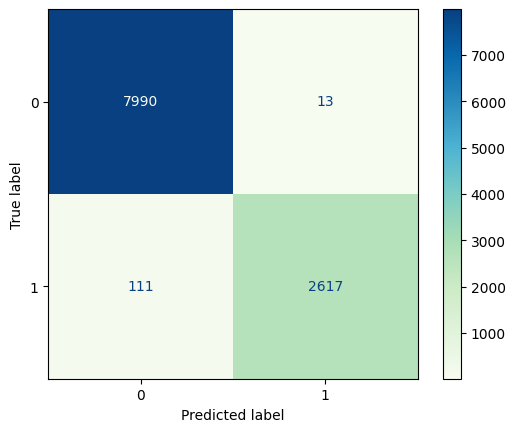

In [ ]:
# plot confusion matrix
metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictions_cnn, cmap = "GnBu")

In [ ]:
### model evaluation metrics

# (true positive + true negative)/total
accuracy = sklearn.metrics.accuracy_score(y_test, predictions_cnn)
print("accuracy: " + str(accuracy))

# true positive/(true positive + false positive)
precision = sklearn.metrics.precision_score(y_test, predictions_cnn)
print("precision: " + str(precision))

# true positive/(true positive + false negative)
sensitivity = sklearn.metrics.recall_score(y_test, predictions_cnn)
print("sensitivity: " + str(sensitivity))

# true negative/(true negative + false positive)
specificity = sklearn.metrics.recall_score(y_test, predictions_cnn, pos_label = 0)
print("specificity: " + str(specificity))

# 2 * (precision*recall)/(precision+recall)
f1_score = 2*(precision*sensitivity)/(precision+sensitivity)
print("f1_score: " + str(f1_score))

# no false positives means precision and specificity will be 100%

accuracy: 0.9884446929456714
precision: 0.9950570342205323
sensitivity: 0.9593108504398827
specificity: 0.9983756091465701
f1_score: 0.97685703620754


In [ ]:
# save model
#cnn_model.save('../Snakes-or-No-Snakes/cnn_final_seed1_3e')

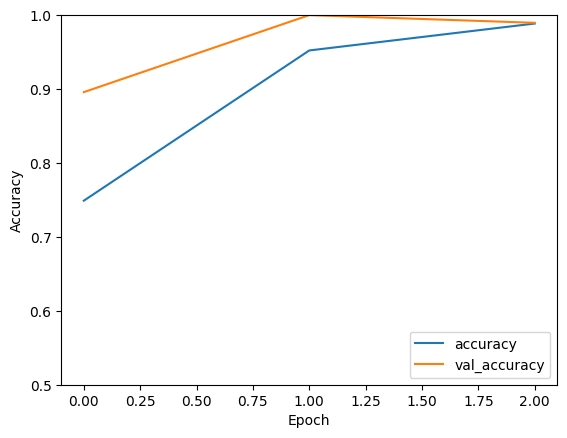

In [ ]:
# plot accuracy across epochs
plt.plot(cnn_fit.history['accuracy'], label='accuracy')
plt.plot(cnn_fit.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')